# Raytracing

The goal of this worksheet is for you to write a simple raytracer. That is, a program that takes a 3D model and generates an image of what it looks like from a particular camera angle (this is called _rendering_). In this case the 3D model will be represented by a _signed distance function_, which makes rendering particularly easy.


## Raytracing with Ray Marching

Real light gets emitted from a light source and then bounces from surface to surface around the world. Some of it may hit a camera, where it is absorbed and generates an electrical current, which is interpreted as an image. For instance, a ray of light may be emitted from the sun, hurtle across the vacume for 8 minutes and 19 seconds before descending through the atmosphere to strike a kitten on the head. The light then bounces off the kittens hair and into a camera, just so you can waste your time looking at cute cat images on the internet (Note: It's actually far more complicated than this. For one thing most 'bounces' are actually the light being absorbed then emitted again.).

Raytracing simulates this, but backwards for efficiency. We don't care about rays that never strike the camera. For the purpose of this exercise we are only going to simulate a single step. Our output image is a 2D grid of pixels. For each pixel a ray is fired out towards the scene. It will either miss all of the geometry and fly towards infinity, or it will strike the surface of an object. We can then measure the length of the ray and output a _depth map_, an image colour coded with the depth of each pixel.

Each ray is represented by three pieces of information:
 * It's starting location, a coordinate (length 3 vector).
 * It's direction of travel, a normal, that is a length 3 vector with unit length.
 * How far it has travelled, a scalar.
 
This means we can work out where the end of the ray is as

`end = start + travel * normal`

The main challenge of raytracing is _collision detection_, that is detecting how far a ray can travel before it collides with a surface. Computer games cheat for speed; rendering for film vfx uses ray/triangle interactions with dense 3D geometry, combined with complex data structures for speed. We're going to do something completely different, that is most commonly used to optimise collision detection in physics simulations rather than rendering. A __signed distance function__ (sdf) tells you for every location how far you are from a surface. Imagine placing a sphere at the end of a ray and making it as large as possible before it touches the surface of an object. It's radius is the distance. The distance is left positive if you're outside an object, but negated if you're inside an object.

To collide a ray with a _sdf_ you repeat a simple process: evaluate the sdf at the current end point of the ray then move that far. If the ray is fired directly at the surface you will immediately collide, and the next time you evaluate the _sdf_ you will get 0, and stop moving. Normally rays make glancing blows, and over many iterations get a little closer each time, until they stop moving on the surface of the object. This is the _ray marching algorithm_.

There are many ways to represent a _sdf_. The _sdf_ for a sphere is entirely analytic for instance - just the distance from the centre minus the radius. In this case we will be using _voxels_, quite simply a 3D array where the _sdf_ has been evaluated and stored in every cell. Some have been provided on moodle for you to download and render (as .hdf5 files).

Here is an alternate explanation: http://jamie-wong.com/2016/07/15/ray-marching-signed-distance-functions/ (There are a couple cool videos showing how far this idea can be pushed, plus a more visual explanation)

## Imports

h5py allows hdf5 files to be loaded, so you have a signed distance function to render.

In [1]:
%matplotlib inline

import numpy
import h5py # Feature rich library for reading/writing hdf5 files (designed for storing large nD arrays).
import matplotlib.pyplot as plt

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

It's typical to have a block at the start of a Jupyter workbook to set some parameters. Here we have the resolution of the output image (1024 X 429 is half of DCI 2K Cinemascope, one of the standards for displaying films) and the _field of view_ (fov), which is a standard way of specifying how wide/zoomed in a camera lens is. 24mm is a fairly wide angle lens - this is a good choice for a distance map as we can't see the surface, only depth, which is exaggerated by a wide lens.

In addition the hdf5 file is loaded and the sdf function extracted as a numpy array. There are a number of sdf function files provided on moodle; feel free to try them all out ('Restart and Run All' in the kernel menu can be useful for this). It's wise to keep the below setup until you have a working system however.

In [2]:
# Parameters...
width = 1024
height = 429

fov = 24.0 # Field of view in mm, 35mm equivalent.


# Load signed distance function...
with h5py.File('dragon.hdf5', 'r') as f:
    sdf = numpy.array(f['sdf'])

print('sdf shape =', sdf.shape)

('sdf shape =', (57, 90, 128))


## Start of Rays

Coordinates on a computer are represented at (x, y, z), but when images are stored in arrays they are indexed (y, x). This is more than a little confusing, but the convention we will be using, for consistency with everyone else.

Your first task is to define the _start_ and _normal_ of each pixel in the image. The x values are stored in `start[:,:,0]`, the y values in `start[:,:,1]` and the z values in `start[:,:,2]`.
The code you need to vectorise is (`u` is the x coordinate in the image, `v` the y coordinate, to avoid confusion with the 3D coordinates being written):
```
start[v,u,0] = -0.5 + u / (width-1)
start[v,u,1] = (-0.5 + v / (height-1)) * height / width
start[v,u,2] = 0
```


In [3]:
# Starting position of each ray...
start = numpy.zeros((height, width, 3))


start[:,:,0] = numpy.linspace(-0.5, 0.5, num=width)                                 #x values vectorised
start[:,:,1] = (numpy.linspace(-0.5, 0.5, num=height)* height / width)[:, None]     #y values vectorised, none keyword is used for making the arrays compatible in terms of shape
start[:,:,2] = 0                                                                    #z values vectorised


print(start)

[[[-0.5        -0.20947266  0.        ]
  [-0.49902248 -0.20947266  0.        ]
  [-0.49804497 -0.20947266  0.        ]
  ...
  [ 0.49804497 -0.20947266  0.        ]
  [ 0.49902248 -0.20947266  0.        ]
  [ 0.5        -0.20947266  0.        ]]

 [[-0.5        -0.20849381  0.        ]
  [-0.49902248 -0.20849381  0.        ]
  [-0.49804497 -0.20849381  0.        ]
  ...
  [ 0.49804497 -0.20849381  0.        ]
  [ 0.49902248 -0.20849381  0.        ]
  [ 0.5        -0.20849381  0.        ]]

 [[-0.5        -0.20751497  0.        ]
  [-0.49902248 -0.20751497  0.        ]
  [-0.49804497 -0.20751497  0.        ]
  ...
  [ 0.49804497 -0.20751497  0.        ]
  [ 0.49902248 -0.20751497  0.        ]
  [ 0.5        -0.20751497  0.        ]]

 ...

 [[-0.5         0.20751497  0.        ]
  [-0.49902248  0.20751497  0.        ]
  [-0.49804497  0.20751497  0.        ]
  ...
  [ 0.49804497  0.20751497  0.        ]
  [ 0.49902248  0.20751497  0.        ]
  [ 0.5         0.20751497  0.        ]]

 [

## Direction of Rays

The normal of a pixel is the unit length vector from the origin of the camera through the pixel. In this case the origin is:

`origin = (0, 0, -fov / 36.0)`

The direction for each pixel is `direction = start - origin`. This needs to be normalised, that is the direction vector has to be divided by it's length, which may be calculated as

`length = numpy.sqrt(numpy.square(direction).sum())`


In [4]:
# Direction...
norm = numpy.empty((height, width, 3)) # norm is short for 'normal'.

origin = (0, 0, -fov / 36.0)
direction = start - origin


# Normalise the direction vectors...

length = numpy.sqrt(numpy.square(direction).sum(axis=2))                   #The chosen axis is 2 

norm = direction/length[:,:,None]                                          #direction and length are made compatible in terms of shape using None
print(norm)

[[[-0.58189783 -0.24378337  0.77586377]
  [-0.58114466 -0.24394475  0.77637739]
  [-0.58038999 -0.24410614  0.77689102]
  ...
  [ 0.58038999 -0.24410614  0.77689102]
  [ 0.58114466 -0.24394475  0.77637739]
  [ 0.58189783 -0.24378337  0.77586377]]

 [[-0.58205912 -0.24271145  0.77607882]
  [-0.58130595 -0.24287221  0.77659287]
  [-0.58055129 -0.24303298  0.77710693]
  ...
  [ 0.58055129 -0.24303298  0.77710693]
  [ 0.58130595 -0.24287221  0.77659287]
  [ 0.58205912 -0.24271145  0.77607882]]

 [[-0.58221978 -0.24163864  0.77629304]
  [-0.58146662 -0.24179878  0.77680752]
  [-0.58071196 -0.24195893  0.777322  ]
  ...
  [ 0.58071196 -0.24195893  0.777322  ]
  [ 0.58146662 -0.24179878  0.77680752]
  [ 0.58221978 -0.24163864  0.77629304]]

 ...

 [[-0.58221978  0.24163864  0.77629304]
  [-0.58146662  0.24179878  0.77680752]
  [-0.58071196  0.24195893  0.777322  ]
  ...
  [ 0.58071196  0.24195893  0.777322  ]
  [ 0.58146662  0.24179878  0.77680752]
  [ 0.58221978  0.24163864  0.77629304]]

 [

## Move and rotate into position

The camera has been setup at the origin of the 3D space, at the same location as the object we have loaded into sdf. This is not going to make for a very good render. Ray marching inside an object gets weird fast. We need to move the camera (the `start` and `norm` arrays to get a better view of the object:
 * Move the camera back the right distance to see the entire object.
 * Rotate 30 degrees around x-axis.
 * Rotate 45 degrees around the y-axis.

You can try alternate values later, but the above values should be used until you get your code working, to avoid the risk you point the camera out into space and miss the object entirely.

### Moving back

You should subtract `2 * (max(sdf.shape) * fov) / 36` for the `z` coordinate of each pixels start location (an offset does not affect the normals).

### Rotation 1

A rotation around the x-axis is a multiplication by the matrix
```
[1.0, 0.0, 0.0],
[0.0,   c,   s],
[0.0,  -s,   c]
```
where, for a 30 degree rotation,
```
s = numpy.sin(numpy.pi * 30 / 180)
c = numpy.cos(numpy.pi * 30 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied.

### Rotation 2

A rotation around the y-axis is a multiplication by the matrix
```
[  c, 0.0,   s],
[0.0, 1.0, 0.0],
[ -s, 0.0,   c]
```
where, for a 45 degree rotation,
```
s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied.

__(5 marks)__
 * 1 mark for moving back.
 * 3 marks for first rotation, of which 1 is reserved for using `numpy.einsum()`.
 * 1 mark for second rotation.

In [5]:
# Move back the right distance to see the entire sdf...

start[:,:,2] = start[:,:,2] - 2 * (max(sdf.shape) * fov) / 36                   #Focus out


# Rotate 30 degrees around the x-axis at the origin...

s = numpy.sin(numpy.pi * 30/180)
c = numpy.cos(numpy.pi * 30/180)
rot1 = [[1.0, 0.0, 0.0],
        [0.0,   c,   s],
        [0.0,  -s,   c]]

start = numpy.einsum('vuc,rc->vur',start,rot1)                                 #einsum() used to calculate rotation of start and norm              
norm = numpy.einsum('vuc,rc->vur',norm,rot1)
print(start)
print(norm)


# Rotate 45 degrees around the y-axis at the origin...

s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)
rot2 = [[  c, 0.0,   s],
        [0.0, 1.0, 0.0],
        [ -s, 0.0,   c]]
start = numpy.einsum('vuc,rc->vur',start,rot2)
norm = numpy.einsum('vuc,rc->vur',norm,rot2)
print(start)
print(norm)

[[[  -0.5         -85.51474198 -147.69693258]
  [  -0.49902248  -85.51474198 -147.69693258]
  [  -0.49804497  -85.51474198 -147.69693258]
  ...
  [   0.49804497  -85.51474198 -147.69693258]
  [   0.49902248  -85.51474198 -147.69693258]
  [   0.5         -85.51474198 -147.69693258]]

 [[  -0.5         -85.51389427 -147.69742201]
  [  -0.49902248  -85.51389427 -147.69742201]
  [  -0.49804497  -85.51389427 -147.69742201]
  ...
  [   0.49804497  -85.51389427 -147.69742201]
  [   0.49902248  -85.51389427 -147.69742201]
  [   0.5         -85.51389427 -147.69742201]]

 [[  -0.5         -85.51304657 -147.69791143]
  [  -0.49902248  -85.51304657 -147.69791143]
  [  -0.49804497  -85.51304657 -147.69791143]
  ...
  [   0.49804497  -85.51304657 -147.69791143]
  [   0.49902248  -85.51304657 -147.69791143]
  [   0.5         -85.51304657 -147.69791143]]

 ...

 [[  -0.5         -85.1536201  -147.9054264 ]
  [  -0.49902248  -85.1536201  -147.9054264 ]
  [  -0.49804497  -85.1536201  -147.9054264 ]
  ..

## Firing Rays

We implemented the following per-pixel psuedocode, vectorised to operate on all pixels at the same time:
```
pos = start + travel * norm
sdf_coordinate = (pos+0.5).astype(int)
for i in range(3): # Loop the 3 coordinates.
    if sdf_coordinate[i]<0: sdf_coordinate[i] = 0
    if sdf_coordinate[i]>=sdf.shape[i]: sdf_coordinate[i] = sdf.shape[i] - 1
return sdf[sdf_coordinate]
```


In [6]:
def sign_dist_nn(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""


    pos = start + travel[:,:,None] * norm
    sdf_coordinate = (pos+0.5).astype(int)
    sdf_coordinate[sdf_coordinate < 0] = 0                                           #Lower limit is capped to 0, all negative values will be reassigned zero value
    
    for i in range(3): # Loop the 3 coordinates.
        
        sdf_coordinate[sdf_coordinate[:,:,i] >= sdf.shape[i],i] = sdf.shape[i] - 1   #Upper limit is capped to sdf.shape[i] - 1
        
    return sdf[sdf_coordinate[:,:,0], sdf_coordinate[:,:,1], sdf_coordinate[:,:,2]]  #x, y and z coordinates are returned back as an element of travel 




# Fire!..
travel = numpy.zeros((height, width))
for _ in range(max(sdf.shape)):
    travel += sign_dist_nn(start, norm, travel)
    print(travel)
    travel[travel>1e6] = 1e6 # Safety

    

[[41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 ...
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]]
[[83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 ...
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]]
[[125.81520081 1

[[725.40492249 725.44527817 725.44527817 ... 701.1703186  701.1703186
  701.1703186 ]
 [724.62590408 724.62590408 724.62590408 ... 700.32919693 700.32919693
  700.32919693]
 [723.39260864 723.39260864 723.39260864 ... 700.03725433 700.35090637
  700.35090637]
 ...
 [572.12921429 571.51741505 571.51741505 ... 626.26322746 626.26322746
  626.26322746]
 [571.51741505 571.46843529 571.67433548 ... 626.26322746 626.26322746
  626.26322746]
 [571.67433548 571.67433548 571.65832329 ... 626.26322746 626.26322746
  626.26322746]]
[[758.47151947 757.73461533 757.73461533 ... 736.29388809 736.94380188
  737.60490417]
 [757.69250107 757.69250107 757.01605225 ... 736.10268021 736.10268021
  736.76588058]
 [757.34422302 756.55768967 756.55768967 ... 735.83449554 736.81365204
  736.81365204]
 ...
 [611.98185253 611.37005329 611.37005329 ... 662.69623756 662.69623756
  662.69623756]
 [611.37005329 611.32107353 611.52697372 ... 662.69623756 662.69623756
  662.69623756]
 [611.52697372 611.52697372 611.5

[[1310.00835228 1310.62230682 1311.5749836  ... 1038.14848614
  1040.47744751 1046.22255611]
 [1310.68257332 1311.57504082 1311.08502197 ... 1039.79994678
  1044.48375893 1047.80182552]
 [1310.49283028 1310.32787895 1311.61667633 ... 1042.70553207
  1047.49062061 1050.47776413]
 ...
 [1249.62406445 1249.01226521 1249.01226521 ... 1245.62439919
  1245.62439919 1245.62439919]
 [1249.01226521 1248.96328545 1249.16918564 ... 1245.62439919
  1245.62439919 1245.62439919]
 [1249.16918564 1249.16918564 1249.15317345 ... 1245.62439919
  1245.62439919 1245.62439919]]
[[1351.82444954 1352.43840408 1353.39108086 ... 1057.11155224
  1059.42406082 1065.16916943]
 [1352.49867058 1353.39113808 1352.90111923 ... 1058.76301289
  1063.43037224 1066.74843884]
 [1352.30892754 1352.14397621 1353.43277359 ... 1061.66859818
  1066.43723392 1069.42437744]
 ...
 [1289.47670269 1288.86490345 1288.86490345 ... 1282.05740929
  1282.05740929 1282.05740929]
 [1288.86490345 1288.81592369 1289.02182388 ... 1282.057409

[[1979.06590843 1979.67986298 1980.63253975 ... 1344.99236965
  1346.41747093 1350.91606045]
 [1979.74012947 1980.63259697 1980.14257812 ... 1344.75139523
  1350.36855507 1351.83609867]
 [1979.55038643 1979.3854351  1980.67423248 ... 1347.27907372
  1352.92437649 1353.75070572]
 ...
 [1887.26627636 1886.65447712 1886.65447712 ... 1828.55256081
  1828.55256081 1828.55256081]
 [1886.65447712 1886.60549736 1886.81139755 ... 1828.55256081
  1828.55256081 1828.55256081]
 [1886.81139755 1886.81139755 1886.79538536 ... 1828.55256081
  1828.55256081 1828.55256081]]
[[2020.88200569 2021.49596024 2022.44863701 ... 1369.67378521
  1370.43296051 1374.93155003]
 [2021.55622673 2022.44869423 2021.95867538 ... 1369.43281078
  1374.38404465 1375.20898914]
 [2021.36648369 2021.20153236 2022.49032974 ... 1371.96048927
  1376.93986607 1377.12359619]
 ...
 [1927.1189146  1926.50711536 1926.50711536 ... 1864.98557091
  1864.98557091 1864.98557091]
 [1926.50711536 1926.4581356  1926.6640358  ... 1864.985570

[[2606.30736732 2606.92132187 2607.87399864 ... 1903.87451077
  1900.33410263 1901.26220608]
 [2606.98158836 2607.87405586 2607.38403702 ... 1900.64835262
  1904.28518677 1899.49756145]
 [2606.79184532 2606.626894   2607.91569138 ... 1903.17603111
  1906.84100819 1900.97785378]
 ...
 [2485.05585003 2484.44405079 2484.44405079 ... 2375.04771233
  2375.04771233 2375.04771233]
 [2484.44405079 2484.39507103 2484.60097122 ... 2375.04771233
  2375.04771233 2375.04771233]
 [2484.60097122 2484.60097122 2484.58495903 ... 2375.04771233
  2375.04771233 2375.04771233]]
[[2648.12346458 2648.73741913 2649.6900959  ... 1945.69060802
  1942.15019989 1943.07830334]
 [2648.79768562 2649.69015312 2649.20013428 ... 1942.46444988
  1946.10128403 1941.31365871]
 [2648.60794258 2648.44299126 2649.73178864 ... 1944.99212837
  1948.65710545 1942.79395103]
 ...
 [2524.90848827 2524.29668903 2524.29668903 ... 2411.48072243
  2411.48072243 2411.48072243]
 [2524.29668903 2524.24770927 2524.45360947 ... 2411.480722

[[3233.54882622 3234.16278076 3235.11545753 ... 2531.11596966
  2527.57556152 2528.50366497]
 [3234.22304726 3235.11551476 3234.62549591 ... 2527.88981152
  2531.52664566 2526.73902035]
 [3234.03330421 3233.86835289 3235.15715027 ... 2530.41749001
  2534.08246708 2528.21931267]
 ...
 [3082.8454237  3082.23362446 3082.23362446 ... 2921.54286385
  2921.54286385 2921.54286385]
 [3082.23362446 3082.1846447  3082.39054489 ... 2921.54286385
  2921.54286385 2921.54286385]
 [3082.39054489 3082.39054489 3082.3745327  ... 2921.54286385
  2921.54286385 2921.54286385]]
[[3275.36492348 3275.97887802 3276.93155479 ... 2572.93206692
  2569.39165878 2570.31976223]
 [3276.03914452 3276.93161201 3276.44159317 ... 2569.70590878
  2573.34274292 2568.55511761]
 [3275.84940147 3275.68445015 3276.97324753 ... 2572.23358727
  2575.89856434 2570.03540993]
 ...
 [3122.69806194 3122.0862627  3122.0862627  ... 2957.97587395
  2957.97587395 2957.97587395]
 [3122.0862627  3122.03728294 3122.24318314 ... 2957.975873

[[3902.60638237 3903.22033691 3904.17301369 ... 3200.17352581
  3196.63311768 3197.56122112]
 [3903.28060341 3904.17307091 3903.68305206 ... 3196.94736767
  3200.58420181 3195.7965765 ]
 [3903.09086037 3902.92590904 3904.21470642 ... 3199.47504616
  3203.14002323 3197.27686882]
 ...
 [3720.48763561 3719.87583637 3719.87583637 ... 3504.47102547
  3504.47102547 3504.47102547]
 [3719.87583637 3719.82685661 3720.03275681 ... 3504.47102547
  3504.47102547 3504.47102547]
 [3720.03275681 3720.03275681 3720.01674461 ... 3504.47102547
  3504.47102547 3504.47102547]]
[[3944.42247963 3945.03643417 3945.98911095 ... 3241.98962307
  3238.44921494 3239.37731838]
 [3945.09670067 3945.98916817 3945.49914932 ... 3238.76346493
  3242.40029907 3237.61267376]
 [3944.90695763 3944.7420063  3946.03080368 ... 3241.29114342
  3244.95612049 3239.09296608]
 ...
 [3760.34027386 3759.72847462 3759.72847462 ... 3540.90403557
  3540.90403557 3540.90403557]
 [3759.72847462 3759.67949486 3759.88539505 ... 3540.904035

[[4529.84784126 4530.46179581 4531.41447258 ... 3827.4149847
  3823.87457657 3824.80268002]
 [4530.5220623  4531.4145298  4530.92451096 ... 3824.18882656
  3827.82566071 3823.03803539]
 [4530.33231926 4530.16736794 4531.45616531 ... 3826.71650505
  3830.38148212 3824.51832771]
 ...
 [4318.27720928 4317.66541004 4317.66541004 ... 4050.96617699
  4050.96617699 4050.96617699]
 [4317.66541004 4317.61643028 4317.82233047 ... 4050.96617699
  4050.96617699 4050.96617699]
 [4317.82233047 4317.82233047 4317.80631828 ... 4050.96617699
  4050.96617699 4050.96617699]]
[[4571.66393852 4572.27789307 4573.23056984 ... 3869.23108196
  3865.69067383 3866.61877728]
 [4572.33815956 4573.23062706 4572.74060822 ... 3866.00492382
  3869.64175797 3864.85413265]
 [4572.14841652 4571.98346519 4573.27226257 ... 3868.53260231
  3872.19757938 3866.33442497]
 ...
 [4358.12984753 4357.51804829 4357.51804829 ... 4087.39918709
  4087.39918709 4087.39918709]
 [4357.51804829 4357.46906853 4357.67496872 ... 4087.3991870

[[5157.08930016 5157.7032547  5158.65593147 ... 4454.6564436
  4451.11603546 4452.04413891]
 [5157.76352119 5158.65598869 5158.16596985 ... 4451.43028545
  4455.0671196  4450.27949429]
 [5157.57377815 5157.40882683 5158.69762421 ... 4453.95796394
  4457.62294102 4451.75978661]
 ...
 [4916.06678295 4915.45498371 4915.45498371 ... 4597.46132851
  4597.46132851 4597.46132851]
 [4915.45498371 4915.40600395 4915.61190414 ... 4597.46132851
  4597.46132851 4597.46132851]
 [4915.61190414 4915.61190414 4915.59589195 ... 4597.46132851
  4597.46132851 4597.46132851]]
[[5198.90539742 5199.51935196 5200.47202873 ... 4496.47254086
  4492.93213272 4493.86023617]
 [5199.57961845 5200.47208595 5199.98206711 ... 4493.24638271
  4496.88321686 4492.09559155]
 [5199.38987541 5199.22492409 5200.51372147 ... 4495.7740612
  4499.43903828 4493.57588387]
 ...
 [4955.9194212  4955.30762196 4955.30762196 ... 4633.89433861
  4633.89433861 4633.89433861]
 [4955.30762196 4955.2586422  4955.46454239 ... 4633.89433861

## Visualisation

The below code will visualise the travel distance in Jupyter. valid is detecting which rays have fired off to infinity and which have converged to the surface of the object, so the background can be masked out. The range is adjusted to look good.


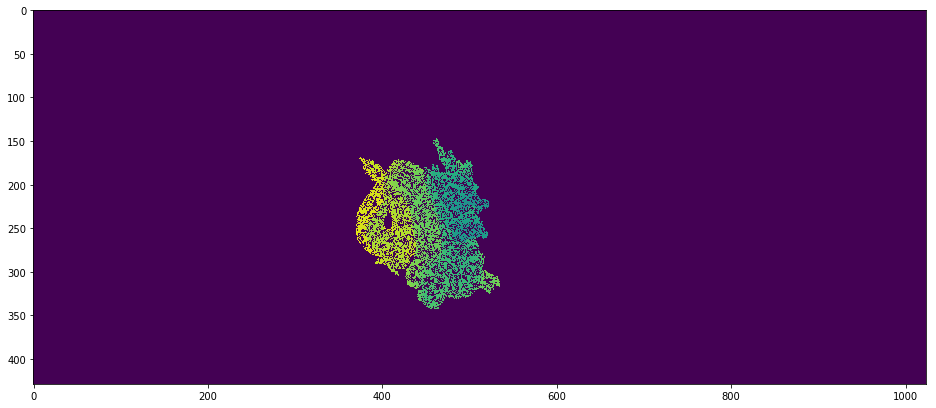

In [7]:
valid = sign_dist_nn(start, norm, travel) < 0.1
image = travel.copy()
image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)

## Linear Interpolation

The above render glitched because it jumps betwen the values in the sdf function; the problem is fixed by interpolating betwen the values. We can solve this with linear interpolation.
In 1D linear interpolation is
```
base = int(x)
t = x - base
value = (1-t) * sdf[base] + t * sdf[int(x)+1]
```
In three dimensions it is called trilinear interpolation, and can be coded as
```
base_x = int(x)
base_y = int(y)
base_z = int(z)
tx = x - base_x
ty = y - base_y
tz = z - base_z

value = 0
for oz in range(2):
  for oy in range(2):
    for ox in range(2):
      weight = 1.0
      if oz==0: weight *= 1 - tz
      else: weight *= tz
      if oy==0: weight *= 1 - ty
      else: weight *= ty
      if ox==0: weight *= 1 - tx
      else: weight *= tx
      value += weight * sdf[base_z+oz, base_y+oy, base_x+ox]
```

In [8]:
def sign_dist_linear(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""
    
    pos = start + travel[:,:,None] * norm
    sdf_coordinate = (pos+0.5)
    sdf_coordinate[sdf_coordinate < 0] = 0
    
    for i in range(3): # Loop the 3 coordinates.
        
        sdf_coordinate[sdf_coordinate[:,:,i] >= sdf.shape[i]-1,i] = sdf.shape[i] - 2         #Upper limit is capped to sdf.shape[i] - 2, this is the tighter bounds check 
    
    x = sdf_coordinate[:,:,0]                                                                #x, y and z values are alotted from the sdf_coordinate array
    y = sdf_coordinate[:,:,1]
    z = sdf_coordinate[:,:,2]
    
    base_x = x.astype(int)                                                                   #astype(int) is used to convert the tuple values to integer    
    base_y = y.astype(int)
    base_z = z.astype(int)
    tx = x - base_x                                                                          #finding difference between the sdf_coordinate and base values
    ty = y - base_y
    tz = z - base_z
    
    tx = numpy.clip(tx, 0, 1)                                                                #capping the upper and lower limit of t arrays' values to 0 and 1
    ty = numpy.clip(ty, 0, 1)
    tz = numpy.clip(tz, 0, 1)
    
    
    value = 0
    for oz in range(2):
        for oy in range(2):
            for ox in range(2):
                weight = 1.0
                if oz==0: weight *= (1 - tz)
                else: weight *= tz
                if oy==0: weight *= (1 - ty)
                else: weight *= ty
                if ox==0: weight *= (1 - tx)
                else: weight *= tx   
                value += weight * sdf[base_x+ox, base_y+oy, base_z+oz]                       #reversing the order of arguments of sdf function to avoid index out of bounds error 
     
    return value
    pass



# Fire!..
better_travel = numpy.zeros((height, width))
for _ in range(max(sdf.shape)):
    better_travel += sign_dist_linear(start, norm, better_travel)
    print(better_travel)
    better_travel[better_travel>1e6] = 1e6 # Safety

[[41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 ...
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]
 [41.93840027 41.93840027 41.93840027 ... 41.93840027 41.93840027
  41.93840027]]
[[83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 ...
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]
 [83.87680054 83.87680054 83.87680054 ... 83.87680054 83.87680054
  83.87680054]]
[[125.81520081 1

[[720.52115355 720.38773692 720.25425702 ... 693.37989801 693.44046251
  693.50174785]
 [719.45637561 719.32531374 719.19418666 ... 692.90888182 692.96717003
  693.02541895]
 [718.42254608 718.29439451 718.16630856 ... 692.46928575 692.52341098
  692.57749565]
 ...
 [563.09396435 562.97954208 562.87236487 ... 618.4639246  618.50824521
  618.55376169]
 [562.85854925 562.75328926 562.65198819 ... 618.36396842 618.40794625
  618.45193463]
 [562.63973229 562.54035491 562.45292922 ... 618.264795   618.3084296
  618.35207575]]
[[753.16851638 752.5512526  751.93330807 ... 728.50081817 728.97938432
  729.20668861]
 [752.5060732  751.87626864 751.24961197 ... 728.24086653 728.66361327
  728.7217094 ]
 [751.86403618 751.2344084  750.60738426 ... 728.01676473 728.22122625
  728.27515566]
 ...
 [601.72168804 601.60726578 601.50008856 ... 654.09685917 654.14117978
  654.18669626]
 [601.48627294 601.38101295 601.27971188 ... 653.99690299 654.04088082
  654.0848692 ]
 [601.26745599 601.1680786  601.0

[[1240.73234219 1240.58945457 1240.58496494 ...  998.52509247
  1002.29635827 1005.17627367]
 [1241.22219508 1241.10977034 1241.11195255 ... 1000.90834944
  1004.69162249 1008.46065547]
 [1241.72235097 1241.57943819 1241.5842303  ... 1004.27357502
  1008.20236062 1011.35279076]
 ...
 [1181.13754345 1181.02312118 1180.91594397 ... 1188.59087772
  1188.63519834 1188.68071482]
 [1180.90212835 1180.79686836 1180.69556729 ... 1188.49092154
  1188.53489937 1188.57888776]
 [1180.68331139 1180.58393401 1180.49650833 ... 1188.39174812
  1188.43538273 1188.47902888]]
[[1280.89313168 1280.75024406 1280.74575443 ... 1016.45094985
  1020.2785359  1023.24712601]
 [1281.38298457 1281.27055983 1281.27274204 ... 1018.83427778
  1022.67422117 1026.50774259]
 [1281.88314046 1281.74022768 1281.74501979 ... 1022.17895933
  1026.15455922 1029.38753835]
 ...
 [1219.76526714 1219.65084488 1219.54366766 ... 1224.22381229
  1224.26813291 1224.31364939]
 [1219.52985204 1219.42459205 1219.32329098 ... 1224.123856

[[1883.30497402 1883.16208641 1883.15759678 ... 1277.73216307
  1281.5917593  1284.80660969]
 [1883.79482692 1883.68240218 1883.68458439 ... 1280.10884983
  1283.99821087 1288.02177576]
 [1884.29498281 1884.15207003 1884.15686214 ... 1283.44436924
  1287.44545003 1290.89206296]
 ...
 [1799.18112255 1799.06670028 1798.95952307 ... 1758.71783085
  1758.76215146 1758.80766794]
 [1798.94570745 1798.84044746 1798.73914639 ... 1758.61787467
  1758.6618525  1758.70584088]
 [1798.7268905  1798.62751311 1798.54008743 ... 1758.51870125
  1758.56233585 1758.605982  ]]
[[1923.46576351 1923.3228759  1923.31838627 ... 1295.96757887
  1299.5807617  1302.46040169]
 [1923.95561641 1923.84319167 1923.84537388 ... 1298.30174071
  1301.93701806 1305.68349025]
 [1924.4557723  1924.31285952 1924.31765163 ... 1301.65393671
  1305.41018865 1308.53486898]
 ...
 [1837.80884624 1837.69442398 1837.58724676 ... 1794.35076542
  1794.39508603 1794.44060251]
 [1837.57343114 1837.46817116 1837.36687008 ... 1794.250809

[[2525.87760586 2525.73471825 2525.73022861 ... 1787.90999172
  1786.15978529 1783.47289732]
 [2526.36745875 2526.25503402 2526.25721622 ... 1789.1070625
  1787.41649498 1786.47723331]
 [2526.86761464 2526.72470186 2526.72949397 ... 1792.49532526
  1791.03423364 1788.58379726]
 ...
 [2417.22470165 2417.11027939 2417.00310217 ... 2328.84478397
  2328.88910459 2328.93462107]
 [2416.98928655 2416.88402656 2416.78272549 ... 2328.74482779
  2328.78880562 2328.83279401]
 [2416.7704696  2416.67109221 2416.58366653 ... 2328.64565437
  2328.68928898 2328.73293513]]
[[2566.03839535 2565.89550774 2565.8910181  ... 1828.07078121
  1826.32057478 1823.63368681]
 [2566.52824824 2566.41582351 2566.41800571 ... 1829.26785199
  1827.57728447 1826.6380228 ]
 [2567.02840413 2566.88549135 2566.89028346 ... 1832.65611474
  1831.19502313 1828.74458675]
 ...
 [2455.85242535 2455.73800308 2455.63082587 ... 2364.47771854
  2364.52203916 2364.56755564]
 [2455.61701024 2455.51175026 2455.41044918 ... 2364.3777623

[[3168.45023769 3168.30735008 3168.30286045 ... 2430.48262356
  2428.73241712 2426.04552915]
 [3168.94009059 3168.82766585 3168.82984806 ... 2431.67969433
  2429.98912681 2429.04986515]
 [3169.44024648 3169.2973337  3169.30212581 ... 2435.06795709
  2433.60686547 2431.1564291 ]
 ...
 [3035.26828075 3035.15385849 3035.04668127 ... 2898.9717371
  2899.01605771 2899.06157419]
 [3035.03286565 3034.92760567 3034.82630459 ... 2898.87178092
  2898.91575875 2898.95974713]
 [3034.8140487  3034.71467132 3034.62724563 ... 2898.7726075
  2898.8162421  2898.85988825]]
[[3208.61102718 3208.46813957 3208.46364994 ... 2470.64341305
  2468.89320661 2466.20631864]
 [3209.10088008 3208.98845534 3208.99063755 ... 2471.84048382
  2470.1499163  2469.21065464]
 [3209.60103597 3209.45812319 3209.4629153  ... 2475.22874658
  2473.76765496 2471.31721859]
 ...
 [3073.89600445 3073.78158218 3073.67440497 ... 2934.60467167
  2934.64899228 2934.69450876]
 [3073.66058935 3073.55532936 3073.45402829 ... 2934.50471549

[[3811.02286953 3810.87998192 3810.87549228 ... 3073.0552554
  3071.30504896 3068.61816099]
 [3811.51272242 3811.40029769 3811.4024799  ... 3074.25232617
  3072.56175865 3071.62249699]
 [3812.01287831 3811.86996554 3811.87475764 ... 3077.64058893
  3076.17949731 3073.72906093]
 ...
 [3653.31185986 3653.19743759 3653.09026037 ... 3469.09869022
  3469.14301084 3469.18852732]
 [3653.07644475 3652.97118477 3652.86988369 ... 3468.99873404
  3469.04271187 3469.08670026]
 [3652.8576278  3652.75825042 3652.67082473 ... 3468.89956062
  3468.94319523 3468.98684138]]
[[3851.18365902 3851.04077141 3851.03628177 ... 3113.21604489
  3111.46583845 3108.77895048]
 [3851.67351191 3851.56108718 3851.56326939 ... 3114.41311566
  3112.72254814 3111.78328648]
 [3852.1736678  3852.03075503 3852.03554713 ... 3117.80137842
  3116.3402868  3113.88985042]
 ...
 [3691.93958355 3691.82516128 3691.71798407 ... 3504.73162479
  3504.77594541 3504.82146189]
 [3691.70416845 3691.59890846 3691.49760739 ... 3504.6316686

[[4453.59550137 4453.45261375 4453.44812412 ... 3715.62788723
  3713.8776808  3711.19079282]
 [4454.08535426 4453.97292952 4453.97511173 ... 3716.824958
  3715.13439049 3714.19512882]
 [4454.58551015 4454.44259737 4454.44738948 ... 3720.21322076
  3718.75212915 3716.30169277]
 ...
 [4271.35543896 4271.24101669 4271.13383948 ... 4039.22564335
  4039.26996396 4039.31548044]
 [4271.12002385 4271.01476387 4270.9134628  ... 4039.12568717
  4039.169665   4039.21365338]
 [4270.9012069  4270.80182952 4270.71440383 ... 4039.02651375
  4039.07014835 4039.1137945 ]]
[[4493.75629086 4493.61340324 4493.60891361 ... 3755.78867672
  3754.03847029 3751.35158231]
 [4494.24614375 4494.13371901 4494.13590122 ... 3756.98574749
  3755.29517998 3754.35591831]
 [4494.74629964 4494.60338686 4494.60817897 ... 3760.37401025
  3758.91291864 3756.46248226]
 ...
 [4309.98316265 4309.86874039 4309.76156317 ... 4074.85857792
  4074.90289853 4074.94841501]
 [4309.74774755 4309.64248756 4309.54118649 ... 4074.75862174

## Visualisation

Same as before, but if you got your function right the glitches should be fixed.

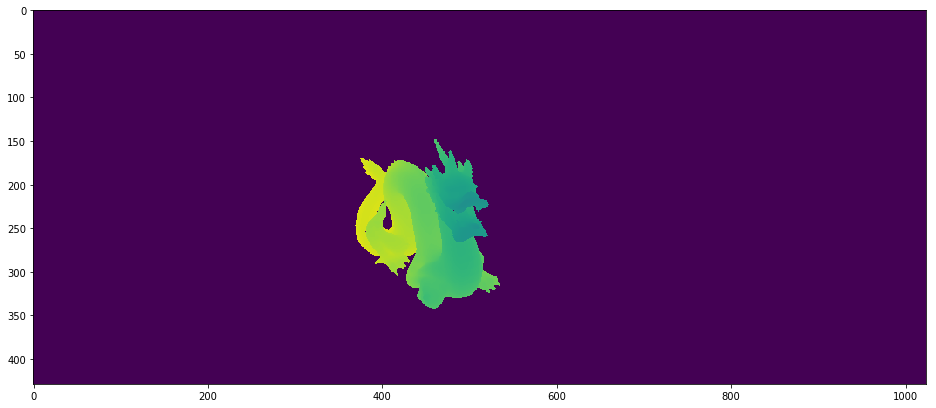

In [9]:
valid = sign_dist_linear(start, norm, better_travel) < 0.1
image = better_travel.copy()
image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)